# Country Aanalysis: Taiwan

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
# convert strings into lists 
import ast
# for ping tests
import requests
from ripe.atlas.cousteau import Ping, AtlasSource, AtlasCreateRequest, AtlasResultsRequest, MeasurementTagger
import logging
from datetime import datetime, timedelta
import multiprocessing as mp
# for mean latencies
import json
import urllib.request

## Loading Data

In [108]:
df = pd.read_csv('../data/processed_results_20240226_filtered_path_org_anycast.csv', keep_default_na=False) 

In [109]:
tw_df = df[df.country == "Taiwan"]

### Number of Traceroutes

In [110]:
numOfTr = len(tw_df)
print("Number of Traceroutes collected for Taiwan: ", numOfTr)

Number of Traceroutes collected for Taiwan:  988


### Number of Unique Websites

In [111]:
numOfUniqueWebsites = len(set(tw_df.dst_url))
print("Number of Unique websites for Taiwan: ", numOfUniqueWebsites)

Number of Unique websites for Taiwan:  99


### Number of Unique Ripe Atlas Probes

In [112]:
numOfUniqueProbes = len(set(tw_df.probe_ids))
print("Number of Unique RIPE Atlas probes: ", numOfUniqueProbes)

Number of Unique RIPE Atlas probes:  10


### Number of Convergent Traceroutes and Percentage

In [113]:
numOfConvergentTr = len(tw_df[tw_df.country == tw_df.dst_country_name])
perOfConvergentTr = "{:.2f}".format((numOfConvergentTr / numOfTr) * 100)

print("Number of convergent traceroutes for Taiwan: ", numOfConvergentTr)
print("Percentage of convergent traceroutes: ", perOfConvergentTr, "%")

Number of convergent traceroutes for Taiwan:  886
Percentage of convergent traceroutes:  89.68 %


### Number of Divergent Traceroutes and Percentage

In [114]:
numOfDivergentTr = len(tw_df[tw_df.country != tw_df.dst_country_name])
perOfDivergentTr = "{:.2f}".format((numOfDivergentTr / numOfTr) * 100)

print("Number of divergent traceroutes for Taiwan: ", numOfDivergentTr)
print("Percentage of divergent traceroutes: ", perOfDivergentTr, "%")

Number of divergent traceroutes for Taiwan:  102
Percentage of divergent traceroutes:  10.32 %


### Number of Violators and Percentage

In [115]:
numOfViolatorsTr = len(tw_df[tw_df.is_violator == True])
perOfViolatorsTr = "{:.2f}".format((numOfViolatorsTr / numOfTr) * 100)

print("Number of violator traceroutes for Taiwan: ", numOfViolatorsTr)
print("Percentage of violator traceroutes: ", perOfViolatorsTr, "%")

Number of violator traceroutes for Taiwan:  153
Percentage of violator traceroutes:  15.49 %


### Freq of Destination Countries in Divergent Traceroutes

In [116]:
dfTaiwanDivergent = tw_df[tw_df.country != tw_df.dst_country_name]
dfTaiwanDivergent["dst_country_name"].value_counts()


dst_country_name
USA    102
Name: count, dtype: int64

### Violator Countries Freq and Percentage

In [117]:
violators = tw_df[tw_df.is_violator == True] 
# convert the string of traceroutes to a list 
try:
    countries = ast.literal_eval(violators['violator_countries'])
except:
    countries = violators['violator_countries']
list_countries = []
for country in countries:
    if pd.isnull(country):
        continue
    else:
        list_from_string = ast.literal_eval(country)        
        list_countries.append(list_from_string)
violator_dict = {}
for i in list_countries:
    for j in i:
        if j in violator_dict.keys():
            violator_dict[j] = violator_dict[j]+1
        else:
            violator_dict[j] = 1
print("Violator countries with corresponding number of traceroutes:", violator_dict) 
violator_df = pd.DataFrame(violator_dict.keys(), columns =['Country Name'])
per_list = []
total = 0 
for i in violator_dict.values():
    total+=i
for i in violator_dict.values():
    per_list.append(round((i/total)*100,2))
violator_df['Percentage of Violators'] = per_list

Violator countries with corresponding number of traceroutes: {'HK': 116, 'JP': 38, 'US': 30, 'TH': 1}


### Histogram with the Violator Countries and Percentage of Violators

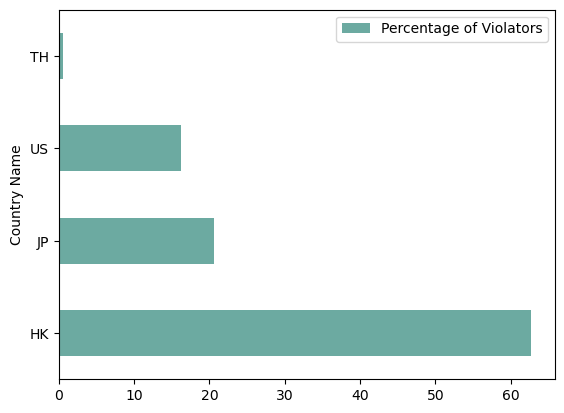

In [118]:
color = (0.1, # redness
         0.3, # greenness
         0.5, # blueness
         0.7 # transparency
        )
         
violator_df.plot.barh(x='Country Name', y='Percentage of Violators', stacked=True, color='#6caaa1')
plt.savefig('tw.png')

### Ping Tests

In [119]:
!pip install ripe.atlas.cousteau

In [120]:
probes_tw = '6818,61078,6907,20503,1002288,1004171'
ATLAS_API_KEY = None #insert API key

In [ ]:
def schedule_ping(target_ip, probes=probes_tw ):
    ping = Ping(af = 4, target = target_ip, description = "Ping to " + target_ip , protocol = 'TCP')
    source = AtlasSource(requested = 6, type = 'probes', value=probes)
    tagger = MeasurementTagger(key=ATLAS_API_KEY)
    atlas_request = AtlasCreateRequest(
        key = ATLAS_API_KEY, 
        measurements = [ping], 
        sources = [source], 
        is_oneoff = True
    )
    logger.info('Scheduling v4 ping measurements from probes to %s', target_ip)
    is_success, response = atlas_request.create()
    if is_success:
        msm_id = response['measurements'][0]
#         tagger.add_tag(msm_id, 'cc_diff_tr')
        logger.info('Done - Scheduled v4 ping measurements from probes to %s, id %s', target_ip, msm_id)
    else:
        logger.error('ERROR - cannot schedule v4 ping measurements from probes to %s', target_ip)
        logger.error(response)
        raise StopIteration('cannot schedule ping measurements from probes to {}'.format(target_ip))
    return is_success, response


schedule_ping('223.200.155.67')

### Calculate Mean Latencies

In [121]:
measurement_id = "67941883" # change the measurement id 
url = "https://atlas.ripe.net/api/v2/measurements/"+measurement_id+"/results/?format=json"
filename = "diff_hops.json"
urllib.request.urlretrieve(url, filename)
content_type = urllib.request.urlopen(url).headers.get_content_type()

In [122]:
f = open(filename)
#load data from site into a json
data_new = json.load(f)
#has mean latencies for each probe
diff ={}
for i in data_new:
    diff_curr = []
    for j in range(len(i['result'])-1):
        max1 = -1;
        for m in i['result'][j]['result']:
            if (m.get('rtt')):
                max1 = max(m['rtt'],max1)
        max2 = -1;
        for m in i['result'][j+1]['result']:
            if (m.get('rtt')):
                max2 = max(m['rtt'],max2)
        if (max1 !=-1 and max2 != -1):
            diff_curr.append(round(max2-max1,3))
        else:
            diff_curr.append('0') 
    diff[i['prb_id']]= diff_curr
for i in diff:
    print(i, ":",diff[i])

1002288 : [0.957, 4.001, 20.183, -18.883, 0.471, 0.196, -0.119, 0.099, 0.53, 2.088, '0', '0', '0', '0', '0', '0']
1002754 : [-1.281, 0.424, -0.267, 0.351, 0.555, -0.383, '0', '0', '0', '0', '0', '0']
1004171 : [0.286, 1.385, -0.621, 1.115, -0.834, 3.948, -1.039, 0.52, 0.104, -0.126, 0.6, '0', '0', '0', '0', '0', '0', '0', '0']
13961 : [6.799, '0', '0', '0', -0.801, 0.056, 3.004, -2.746, 11.314, -11.284, 8.474, -7.028, -1.513, 16.293, '0', '0', '0', '0', '0', '0']
20503 : [1.022, 1.179, 6.343, -4.545, 1.905, 0.638, -2.045, '0', '0', '0', '0', '0', '0']
61078 : [41.258, -3.621, -1.583, 25.021, 0.427, '0', '0', -0.543, '0', '0', '0', '0', '0', '0']
61200 : [0.127, 0.24, 0.259, '0', '0', -0.417, '0', '0', '0', '0', '0', '0']
62859 : [1.386, 0.171, 14.395, -14.391, 0.684, 1.81, -1.666, 0.325, 0.652, -0.394, '0', '0', '0', '0', '0', '0']
6818 : [78.502, 105.926, -78.977, 0.312, 34.804, '0', '0', '0', '0', '0', '0']
6907 : [1.547, '0', '0', -0.005, 195.202, -67.647, 0.106, -0.028, -11.012, 7.

### To get a more in-depth analysis, filter data based on the interesting behavior

In [144]:
#filter violator traceroutes based on probes
tw_df[(tw_df.probe_ids == 6818) & (tw_df.is_violator == True)] 

#filter convergent violator traceroutes based on probes
tw_df[(tw_df.probe_ids == 61200) & (tw_df.is_violator == True) & (tw_df.is_convergent == False)] 

#filter violator traceroutes of a probe based on a specific destination
subset = tw_df[(tw_df.is_violator) & (tw_df.probe_ids == 61078)]
subset[subset.dst_org == "National Chung Hsing University"]

#filter based on measurement id (acquired from ripe Atlas measurements)
tw_df[tw_df.measurement_id == 67941624]

#mix any of these and other relevant filters to find specific patterns in the data


,country,dst_url,measurement_id,probe_ids,probe_addr,dst_addr,path_ip,mean_latencies,path_geo,dst_country,...,is_gcloud,is_cloudflare,is_major_cloud,is_cloud,dst_asn,dst_org,path_asns,path_orgs,dst_prefix,dst_is_anycast
13725,Taiwan,www.trade.gov.tw,67941624,1002288,172.17.0.2,210.69.123.210,"['172.17.0.1', '192.168.109.254', '106.104.194...","[0.23, 1.15, 5.36, 5.2, 7.45, 6.71, 7.36, 7.08...","['??', '??', 'TW', 'TW', 'TW', 'TW', 'TW', 'TW...",TW,...,False,False,False,False,4782,"Data Communication Business Group,","['noasn', 'noasn', '4780', '4780', '4780', '47...","[None, None, 'Digital United Inc.', 'Digital U...",210.69.123,False
13726,Taiwan,www.trade.gov.tw,67941624,1002754,63.222.105.13,210.69.123.210,"['63.222.105.2', '113.21.84.37', '103.123.252....","[0.79, 11.4, 0.82, 0.52, 0.8, 1.25, 1.16, 0.0,...","['TW', 'TW', 'TW', 'TW', 'TW', 'TW', 'TW', '*'...",TW,...,False,False,False,False,4782,"Data Communication Business Group,","['3491_31713', 'noasn', 'noasn', '3462', '3462...","['PCCW Global, Inc.', None, None, 'Chunghwa Te...",210.69.123,False
13727,Taiwan,www.trade.gov.tw,67941624,1004171,172.17.0.2,210.69.123.210,"['172.17.0.1', '10.121.32.1', '61.61.67.254', ...","[0.11, 0.49, 0.92, 1.05, 1.33, 1.29, 4.29, 3.5...","['??', '??', 'TW', '??', '??', '??', 'TW', 'TW...",TW,...,False,False,False,False,4782,"Data Communication Business Group,","['noasn', 'noasn', '18049', 'noasn', 'noasn', ...","[None, None, 'Taiwan Infrastructure Network Te...",210.69.123,False
13728,Taiwan,www.trade.gov.tw,67941624,13961,192.168.0.204,210.69.123.210,"['192.168.0.1', '219.91.21.254', '*', '*', '10...","[0.52, 6.37, 0.0, -1, 0.0, -1, 7.44, 6.33, 5.7...","['??', 'TW', '*', '*', '??', '??', '??', 'TW',...",TW,...,False,False,False,False,4782,"Data Communication Business Group,","['noasn', '131627', 'noasn', 'noasn', 'noasn',...","[None, 'Peicity Digital Cable Television., LTD...",210.69.123,False
13729,Taiwan,www.trade.gov.tw,67941624,20503,192.168.100.102,210.69.123.210,"['192.168.100.1', '192.168.111.1', '140.115.30...","[0.41, 1.46, 2.61, 3.2, 3.34, 4.33, 4.11, 5.12...","['??', '??', 'TW', 'TW', 'TW', 'TW', 'TW', 'TW...",TW,...,False,False,False,False,4782,"Data Communication Business Group,","['noasn', 'noasn', '18420', '3462', '3462', 'n...","[None, None, 'National Central University', 'C...",210.69.123,False
13730,Taiwan,www.trade.gov.tw,67941624,61078,103.167.250.61,210.69.123.210,"['103.167.250.33', '103.138.72.36', '63.222.11...","[2.11, 37.6, 39.44, 25.49, 65.95, 63.2, 0.0, -...","['TW', 'HK', 'HK', 'HK', 'TW', 'TW', '*', 'TW'...",TW,...,False,False,False,False,4782,"Data Communication Business Group,","['38254', '138997', '3491_31713', '3491_31713'...","['Pang-Wei Tsai', 'Eons Data Communications Li...",210.69.123,False
13731,Taiwan,www.trade.gov.tw,67941624,61200,103.159.119.3,210.69.123.210,"['103.159.119.2', '172.18.1.157', '172.24.1.11...","[0.54, 1.44, 1.07, 1.62, 0.0, -1, 2.03, 1.69, ...","['TW', '??', '??', '??', '*', 'TW', 'TW', '*',...",TW,...,False,False,False,False,4782,"Data Communication Business Group,","['38856', 'noasn', 'noasn', 'noasn', 'noasn', ...","['Walks Cloud Inc.', None, None, None, None, N...",210.69.123,False
13732,Taiwan,www.trade.gov.tw,67941624,62859,192.168.8.199,210.69.123.210,"['192.168.8.254', '118.150.144.254', '10.254.0...","[0.78, 2.31, 2.27, 4.49, 2.4, 2.95, 3.45, 2.91...","['??', 'TW', '??', '??', '??', 'TW', 'TW', 'TW...",TW,...,False,False,False,False,4782,"Data Communication Business Group,","['noasn', '18419', 'noasn', 'noasn', 'noasn', ...","[None, 'DaDa Broadband LTD.', None, None, None...",210.69.123,False
13733,Taiwan,www.trade.gov.tw,67941624,6818,63.222.40.114,210.69.123.210,"['63.222.40.113', '63.218.174.66', '211.22.33....","[0.95, 26.49, 106.52, 106.75, 107.28, 107.04, ...","['TW', 'HK', 'TW', 'TW', 'TW', 'TW', '*', '*',...",TW,...,False,False,False,False,4782,"Data Communication Business Group,","['3491_31713', '3491_31713', '3462', 'noasn', ...","['PCCW Global, Inc.', 'PCCW Gl

In [124]:
# use to loop through fielterd data and display selected information based on columns
# this loop is spefically looking for the ip '211.72.108.54' and printing out the clean traceroute and path_ip
for index, row in tw_df.iterrows():
    if (row["is_violator"] == True and '211.72.108.54' in row["path_ip"]):
        print(row["clean_traceroute"])
        print(row["path_ip"])

['TW', 'TW', 'JP', 'JP', 'US', 'US', 'US', 'US', 'US', 'TW', 'TW', 'TW', 'TW']
['103.153.176.254', '103.51.91.5', '*', '66.28.4.233', '154.54.83.190', '154.54.1.21', '154.54.42.101', '154.54.27.118', '38.19.140.82', '202.39.84.86', '211.72.108.54', '220.128.6.114', '220.128.11.150', '220.128.3.189', '*', '*', '*', '*', '*', '*']
['TW', 'TW', 'JP', 'JP', 'US', 'US', 'US', 'US', 'US', 'TW', 'TW', 'TW', 'TW']
['103.153.176.254', '103.51.91.5', '*', '66.28.4.233', '154.54.83.190', '154.54.1.21', '154.54.42.101', '154.54.27.118', '38.19.140.82', '202.39.84.86', '211.72.108.54', '220.128.6.114', '220.128.13.94', '220.128.1.253', '*', '*', '*', '*', '*', '*']
['TW', 'TW', 'JP', 'JP', 'US', 'US', 'US', 'US', 'US', 'US', 'TW', 'TW', 'TW', 'TW']
['103.153.176.254', '103.51.91.5', '*', '66.28.4.233', '154.54.83.190', '154.54.86.137', '154.54.5.101', '154.54.40.145', '154.54.3.70', '38.19.140.82', '202.39.84.86', '211.72.108.54', '220.128.31.10', '220.128.14.94', '220.128.2.249', '*', '*', '*', '*

### Make a String into a List 

In [125]:
def stringToList(inputStr):
    try:
        paths = ast.literal_eval(inputStr)
    except:
        paths  = inputStr
    outputList = []
    for path in paths:
        if pd.isnull(path):
            continue
        else:
            list_from_string = ast.literal_eval(path)        
            outputList.append(list_from_string)

    return outputList

### To find similarities/patterns between path ips/asns, compare violator and non-violator traceroutes 

In [129]:
#convert ip strings to list; could also be done for asn or anything that needs to be analyzed
violator_ips = stringToList(tw_df[(tw_df.probe_ids == 6818) & (tw_df.is_violator == True)].path_ip)
nonviolator_ips = stringToList(tw_df[(tw_df.probe_ids == 6818) & (tw_df.is_violator == False)].path_ip)

for nonviolator_ip in nonviolator_ips:
        for violator_ip in violator_ips:    
            #change based on the pattern you have observed
            if (violator_ip[2:-2] == nonviolator_ip[2:-2]): 
                print(violator_ip)
                print(nonviolator_ip)
                print()
                break

['63.222.40.113', '63.218.174.66', '211.22.33.166', '220.128.6.226', '220.128.3.162', '220.128.7.113', '220.128.11.133', '202.39.91.77', '202.39.84.46', '202.39.82.1', '168.95.245.3']
['63.222.40.113', '*', '211.22.33.166', '220.128.6.226', '220.128.3.162', '220.128.7.113', '220.128.11.133', '202.39.91.77', '202.39.84.46', '202.39.82.1', '168.95.245.3']

['63.222.40.113', '63.218.174.66', '211.22.33.166', '220.128.6.250', '220.128.2.110', '*', '220.128.11.133', '202.39.91.77', '202.39.84.46', '202.39.82.1', '168.95.245.4']
['63.222.40.113', '*', '211.22.33.166', '220.128.6.250', '220.128.2.110', '*', '220.128.11.133', '202.39.91.77', '202.39.84.46', '202.39.82.1', '168.95.245.4']

['63.222.40.113', '63.218.174.126', '63.218.115.234', '45.60.149.40']
['63.222.40.113', '63.223.9.102', '63.217.71.126', '104.18.27.27']

['63.222.40.113', '63.218.174.126', '63.218.115.234', '45.60.149.40']
['63.222.40.113', '63.223.9.102', '63.217.71.126', '104.18.21.69']

['63.222.40.113', '63.218.174.66',

# Country Aanalysis: China

## Loading Data

In [130]:
#filter out probes 50179 and 7030 because they are in Hong Kong
cn_df = df[(df.country == "China") & (df.probe_ids != 50179) & (df.probe_ids != 7030)] 

### Number of Traceroutes

In [131]:
numOfTr = len(cn_df)
print("Number of Traceroutes collected for China: ", numOfTr)

Number of Traceroutes collected for China:  687


### Number of Unique Websites

In [132]:
numOfUniqueWebsites = len(set(cn_df.dst_url))
print("Number of Unique websites for Taiwan: ", numOfUniqueWebsites)

Number of Unique websites for Taiwan:  99


### Number of Unique Ripe Atlas Probes

In [133]:
numOfUniqueProbes = len(set(cn_df.probe_ids))
print("Number of Unique RIPE Atlas probes: ", numOfUniqueProbes)

Number of Unique RIPE Atlas probes:  7


### Number of Convergent Traceroutes and Percentage

In [134]:
numOfConvergentTr = len(cn_df[cn_df.country == cn_df.dst_country_name])
perOfConvergentTr = "{:.2f}".format((numOfConvergentTr / numOfTr) * 100)

print("Number of convergent traceroutes for China: ", numOfConvergentTr)
print("Percentage of convergent traceroutes: ", perOfConvergentTr, "%")

Number of convergent traceroutes for China:  678
Percentage of convergent traceroutes:  98.69 %


### Number of Divergent Traceroutes and Percentage

In [135]:
numOfDivergentTr = len(cn_df[cn_df.country != cn_df.dst_country_name])
perOfDivergentTr = "{:.2f}".format((numOfDivergentTr / numOfTr) * 100)

print("Number of divergent traceroutes for China: ", numOfDivergentTr)
print("Percentage of divergent traceroutes: ", perOfDivergentTr, "%")

Number of divergent traceroutes for China:  9
Percentage of divergent traceroutes:  1.31 %


### Number of Violators and Percentage

In [136]:
numOfViolatorsTr = len(cn_df[cn_df.is_violator == True])
perOfViolatorsTr = "{:.2f}".format((numOfViolatorsTr / numOfTr) * 100)

print("Number of violator traceroutes for China: ", numOfViolatorsTr)
print("Percentage of violator traceroutes: ", perOfViolatorsTr, "%")

Number of violator traceroutes for China:  27
Percentage of violator traceroutes:  3.93 %


### Freq of Destination Countries in Divergent Traceroutes

In [137]:
dfChinaDivergent = cn_df[cn_df.country != cn_df.dst_country_name]
dfChinaDivergent["dst_country_name"].value_counts()


dst_country_name
USA    9
Name: count, dtype: int64

### Violator Countries Freq and Percentage

In [138]:
violators = cn_df[cn_df.is_violator == True] 
# convert the string of traceroutes to a list 
try:
    countries = ast.literal_eval(violators['violator_countries'])
except:
    countries = violators['violator_countries']
list_countries = []
for country in countries:
    if pd.isnull(country):
        continue
    else:
        list_from_string = ast.literal_eval(country)        
        list_countries.append(list_from_string)
violator_dict = {}
for i in list_countries:
    for j in i:
        if j in violator_dict.keys():
            violator_dict[j] = violator_dict[j]+1
        else:
            violator_dict[j] = 1
print("Violator countries with corresponding number of traceroutes:", violator_dict) 
violator_df = pd.DataFrame(violator_dict.keys(), columns =['Country Name'])
per_list = []
total = 0 
for i in violator_dict.values():
    total+=i
for i in violator_dict.values():
    per_list.append(round((i/total)*100,2))
violator_df['Percentage of Violators'] = per_list

Violator countries with corresponding number of traceroutes: {'US': 27}


### Histogram with the Violator Countries and Percentage of Violators

<Axes: ylabel='Country Name'>

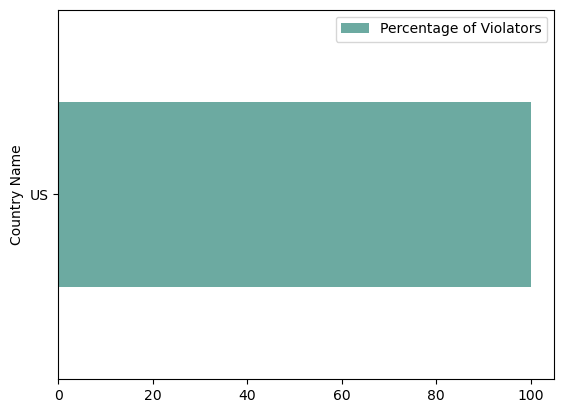

In [139]:
color = (0.1, # redness
         0.3, # greenness
         0.5, # blueness
         0.7 # transparency
        )
         
violator_df.plot.barh(x='Country Name', y='Percentage of Violators', stacked=True, color='#6caaa1')

### Ping Tests

In [140]:
probes_cn = '1003540,1005736,1005738,1005739,53274,55328'
ATLAS_API_KEY = None #insert API key

In [ ]:
def schedule_ping(target_ip, probes=probes_cn ):
    ping = Ping(af = 4, target = target_ip, description = "Ping to " + target_ip , protocol = 'TCP')
    source = AtlasSource(requested = 6, type = 'probes', value=probes)
    tagger = MeasurementTagger(key=ATLAS_API_KEY)
    atlas_request = AtlasCreateRequest(
        key = ATLAS_API_KEY, 
        measurements = [ping], 
        sources = [source], 
        is_oneoff = True
    )
    logger.info('Scheduling v4 ping measurements from probes to %s', target_ip)
    is_success, response = atlas_request.create()
    if is_success:
        msm_id = response['measurements'][0]
#         tagger.add_tag(msm_id, 'cc_diff_tr')
        logger.info('Done - Scheduled v4 ping measurements from probes to %s, id %s', target_ip, msm_id)
    else:
        logger.error('ERROR - cannot schedule v4 ping measurements from probes to %s', target_ip)
        logger.error(response)
        raise StopIteration('cannot schedule ping measurements from probes to {}'.format(target_ip))
    return is_success, response


schedule_ping('223.200.155.67')

### To get a more in-depth analysis, filter data based on the interesting behavior

In [154]:
#filter violator traceroutes based on probes
cn_df[(cn_df.probe_ids == 1005736) & (cn_df.is_violator == True)] 

#filter convergent non-violator traceroutes based on probes
tw_df[(tw_df.probe_ids == 1005739) & (tw_df.is_violator == False) & (tw_df.is_convergent == False)] 

#filter violator traceroutes of a probe based on a specific destination
subset = tw_df[(tw_df.is_violator) & (tw_df.probe_ids == 1005736)]
subset[subset.dst_org == "Alibaba (US) Technology Co., Ltd."]

#filter based on measurement id (acquired from ripe Atlas measurements)
cn_df[cn_df.measurement_id == 68064769]

#mix any of these and other relevant filters to find specific patterns in the data


,country,dst_url,measurement_id,probe_ids,probe_addr,dst_addr,path_ip,mean_latencies,path_geo,dst_country,...,is_gcloud,is_cloudflare,is_major_cloud,is_cloud,dst_asn,dst_org,path_asns,path_orgs,dst_prefix,dst_is_anycast
3797,China,customs.gov.cn,68064769,1003540,172.19.59.164,202.127.48.0,"['26.10.167.86', '11.73.56.174', '11.73.33.57'...","[1.55, 1.34, 1.35, 1.77, 1.71, 3.42, 0.0, -1, ...","['CN', 'CN', 'CN', 'CN', '??', 'CN', '*', '*',...",CN,...,False,False,False,False,4847,China Networks Inter-Exchange,"['749', '749', '749', '749', 'noasn', '749', '...","['DoD Network Information Center', 'DoD Networ...",202.127.48,False
3798,China,customs.gov.cn,68064769,1005736,172.17.0.2,202.127.48.0,"['172.17.0.1', '10.33.116.190', '*', '10.102.1...","[0.1, 1.65, 0.0, -1, 3.6, 4.23, 3.29, 4.3, 4.8...","['??', '??', '*', '??', 'CN', 'CN', 'CN', 'CN'...",CN,...,False,False,False,False,4847,China Networks Inter-Exchange,"['noasn', 'noasn', 'noasn', 'noasn', 'noasn', ...","[None, None, None, None, None, 'DoD Network In...",202.127.48,False
3799,China,customs.gov.cn,68064769,1005738,172.17.0.2,202.127.48.0,"['172.17.0.1', '11.209.113.2', '11.73.4.81', '...","[0.04, 0.14, 6.56, 11.37, 1.38, 1.24, 0.0, -1,...","['??', 'CN', 'CN', 'CN', 'CN', 'CN', '*', 'CN'...",CN,...,False,False,False,False,4847,China Networks Inter-Exchange,"['noasn', '749', '749', '749', '45102', '45102...","[None, 'DoD Network Information Center', 'DoD ...",202.127.48,False
3800,China,customs.gov.cn,68064769,1005739,172.17.0.2,202.127.48.0,"['172.17.0.1', '10.12.32.6', '*', '11.54.240.1...","[0.03, 1.48, 0.0, -1, 1.26, 7.78, 8.85, 0.0, -...","['??', '??', '*', 'CN', '??', 'CN', '*', 'CN',...",CN,...,False,False,False,False,4847,China Networks Inter-Exchange,"['noasn', 'noasn', 'noasn', '749', 'noasn', '7...","[None, None, None, 'DoD Network Information Ce...",202.127.48,False
3802,China,customs.gov.cn,68064769,53274,192.168.1.241,202.127.48.0,"['192.168.1.254', '192.168.1.1', '100.84.128.1...","[1.82, 1.63, 4.66, 6.08, 22.15, 0.0, -1, 29.14...","['??', '??', '??', 'CN', 'CN', '*', 'CN', 'CN'...",CN,...,False,False,False,False,4847,China Networks Inter-Exchange,"['noasn', 'noasn', 'noasn', '4134', '4134', 'n...","[None, None, None, 'No.31,Jin-rong Street', 'N...",202.127.48,False
3803,China,customs.gov.cn,68064769,55328,192.168.1.86,202.127.48.0,"['192.168.1.1', '36.20.60.1', '61.164.19.10', ...","[0.97, 21.87, 2.82, 3.56, 0.0, -1, 0.0, -1, 0....","['??', 'CN', 'CN', 'CN', '*', '*', '*', 'CN', ...",CN,...,False,False,False,False,4847,China Networks Inter-Exchange,"['noasn', '4134', '4134', '4134', 'noasn', 'no...","[None, 'No.31,Jin-rong Street', 'No.31,Jin-ron...",202.127.48,False
3804,China,customs.gov.cn,68064769,60314,192.168.71.43,202.127.48.0,"['192.168.71.1', '180.154.35.1', '61.172.65.20...","[2.85, 3.68, 3.64, 7.08, 0.0, -1, 26.87, 0.0, ...","['??', 'CN', 'CN', 'CN', '*', 'CN', '*', '*', ...",CN,...,False,False,False,False,4847,China Networks Inter-Exchange,"['noasn', '4812', '4812', '4812', 'noasn', '41...","[None, 'China Telecom (Group)', 'China Telecom...",202.127.48,False


In [157]:
# use to loop through fielterd data and display selected information based on columns
# this loop is spefically looking for the ip '172.17.0.1' and printing out the clean traceroute and path_ip
for index, row in cn_df.iterrows():
    if (row["is_violator"] == True and '172.17.0.1' in row["path_ip"]):
        print(row["clean_traceroute"])
        print(row["path_ip"])

['CN', 'CN', 'US', 'CN']
['172.17.0.1', '10.12.32.6', '*', '11.54.240.237', '10.102.107.170', '116.251.112.94', '11.63.103.86', '*', '*', '*', '*', '*', '47.93.95.89']
['CN', 'CN', 'US', 'CN', 'CN']
['172.17.0.1', '10.12.36.6', '*', '11.57.13.41', '103.52.75.58', '11.94.166.53', '116.251.112.209', '103.2.211.132', '*', '*', '*', '*', '*', '*']
['CN', 'US', 'CN', 'CN']
['172.17.0.1', '10.12.32.6', '*', '10.255.99.101', '103.41.141.210', '11.94.166.41', '116.251.115.113', '10.87.106.45', '*', '*', '*', '*', '*', '59.110.244.183']
['CN', 'CN', 'US', 'CN', 'CN']
['172.17.0.1', '10.12.36.6', '*', '11.57.13.41', '103.52.75.58', '11.94.166.53', '116.251.112.209', '103.2.211.132', '*', '*', '*', '*', '*', '*']
['CN', 'US', 'CN', 'CN']
['172.17.0.1', '10.12.44.6', '10.12.32.105', '10.255.99.89', '103.41.141.210', '11.94.166.41', '*', '218.241.244.205', '218.241.254.98', '*', '*', '*', '*', '*', '*']
['CN', 'CN', 'US', 'CN', 'CN']
['172.17.0.1', '10.12.36.6', '*', '11.57.13.41', '103.52.75.58', 

### To find similarities/patterns between path ips/asns, compare violator and non-violator traceroutes 

In [176]:
#convert ip strings to list; could also be done for asn or anything that needs to be analyzed
#not very important for China
violator_ips = stringToList(cn_df[(cn_df.is_violator == True)].path_ip)
nonviolator_ips = stringToList(cn_df[(cn_df.is_violator == False)].path_ip)

for nonviolator_ip in nonviolator_ips:
        for violator_ip in violator_ips:    
            #change based on the pattern you have observed
            if (violator_ip[-1] == nonviolator_ip[-1] and violator_ip[-1] != "*" and nonviolator_ip[-1] != "* "): 
                print(violator_ip)
                print(nonviolator_ip)
                print()
                break

['172.17.0.1', '10.12.32.6', '*', '11.54.240.237', '10.102.107.170', '116.251.112.94', '11.63.103.86', '*', '*', '*', '*', '*', '47.93.95.89']
['26.10.178.78', '11.73.14.17', '11.73.34.89', '11.73.50.89', '10.222.215.153', '*', '140.205.27.221', '11.204.180.169', '11.216.21.166', '*', '*', '*', '*', '*', '47.93.95.89']

['172.17.0.1', '10.12.32.6', '*', '11.54.240.237', '10.102.107.170', '116.251.112.94', '11.63.103.86', '*', '*', '*', '*', '*', '47.93.95.89']
['172.17.0.1', '10.33.120.190', '*', '10.102.15.141', '116.251.118.2', '10.54.221.249', '11.63.103.118', '*', '*', '*', '*', '*', '47.93.95.89']

['172.17.0.1', '10.12.32.6', '*', '11.54.240.237', '10.102.107.170', '116.251.112.94', '11.63.103.86', '*', '*', '*', '*', '*', '47.93.95.89']
['172.17.0.1', '11.209.113.2', '11.73.4.49', '10.54.182.102', '116.251.89.234', '*', '140.205.27.229', '11.211.191.137', '10.48.203.102', '*', '*', '*', '*', '*', '47.93.95.89']

['172.17.0.1', '10.12.32.6', '*', '11.54.240.237', '10.102.107.170'